Khai báo thư viện

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



In [2]:
# Đọc file 
train_data = pd.read_csv('data/train/data_train.csv')
test_data = pd.read_csv('data/train/data_test.csv')


In [3]:
# Separate target from predictors
y_train = train_data["Giá"]
X_train = train_data.drop(['Giá'], axis=1)
y_test = test_data['Giá']
X_test = test_data.drop(['Giá'], axis=1)

In [4]:
X_train.shape

(21124, 17)

Thực hiện mã hóa một lần cho tất cả các tính năng phân loại 

In [5]:
# Identify categorical columns
categorical_cols = [col_name for col_name in X_train.columns if X_train[col_name].dtype in ['object']]

In [6]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
OH_X_train = OH_encoder.fit_transform(X_train[categorical_cols])
OH_X_test = OH_encoder.transform(X_test[categorical_cols])

In [7]:
OH_X_train.shape

(21124, 1658)

In [8]:
# One-hot encoding removed index; put it back
OH_X_train.index = X_train.index
OH_X_test.index = X_test.index

In [9]:
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

In [10]:
# Chuyển đổi ma trận CSR thành DataFrame
OH_X_train_df = pd.DataFrame.sparse.from_spmatrix(OH_X_train)
OH_X_test_df = pd.DataFrame.sparse.from_spmatrix(OH_X_test)

# Kết hợp dữ liệu
X_train_concat = pd.concat([num_X_train, OH_X_train_df], axis=1)
X_test_concat = pd.concat([num_X_test, OH_X_test_df], axis=1)


In [11]:
# Chuyển đổi ma trận CSR thành DataFrame
OH_X_train_df = pd.DataFrame.sparse.from_spmatrix(OH_X_train)
OH_X_test_df = pd.DataFrame.sparse.from_spmatrix(OH_X_test)

# Kết hợp dữ liệu
X_train_concat = pd.concat([num_X_train, OH_X_train_df], axis=1)
X_test_concat = pd.concat([num_X_test, OH_X_test_df], axis=1)


# Multiple Linear Regression 

In [12]:
# Train the model
model = LinearRegression()
model.fit(OH_X_train, y_train)

# Make predictions
y_pred = model.predict(OH_X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 5.6597268028168405e+20
Mean Absolute Error: 496045247.3720675
R^2 Score: 0.004606414312149809


### Đánh giá....

#### visulaization 

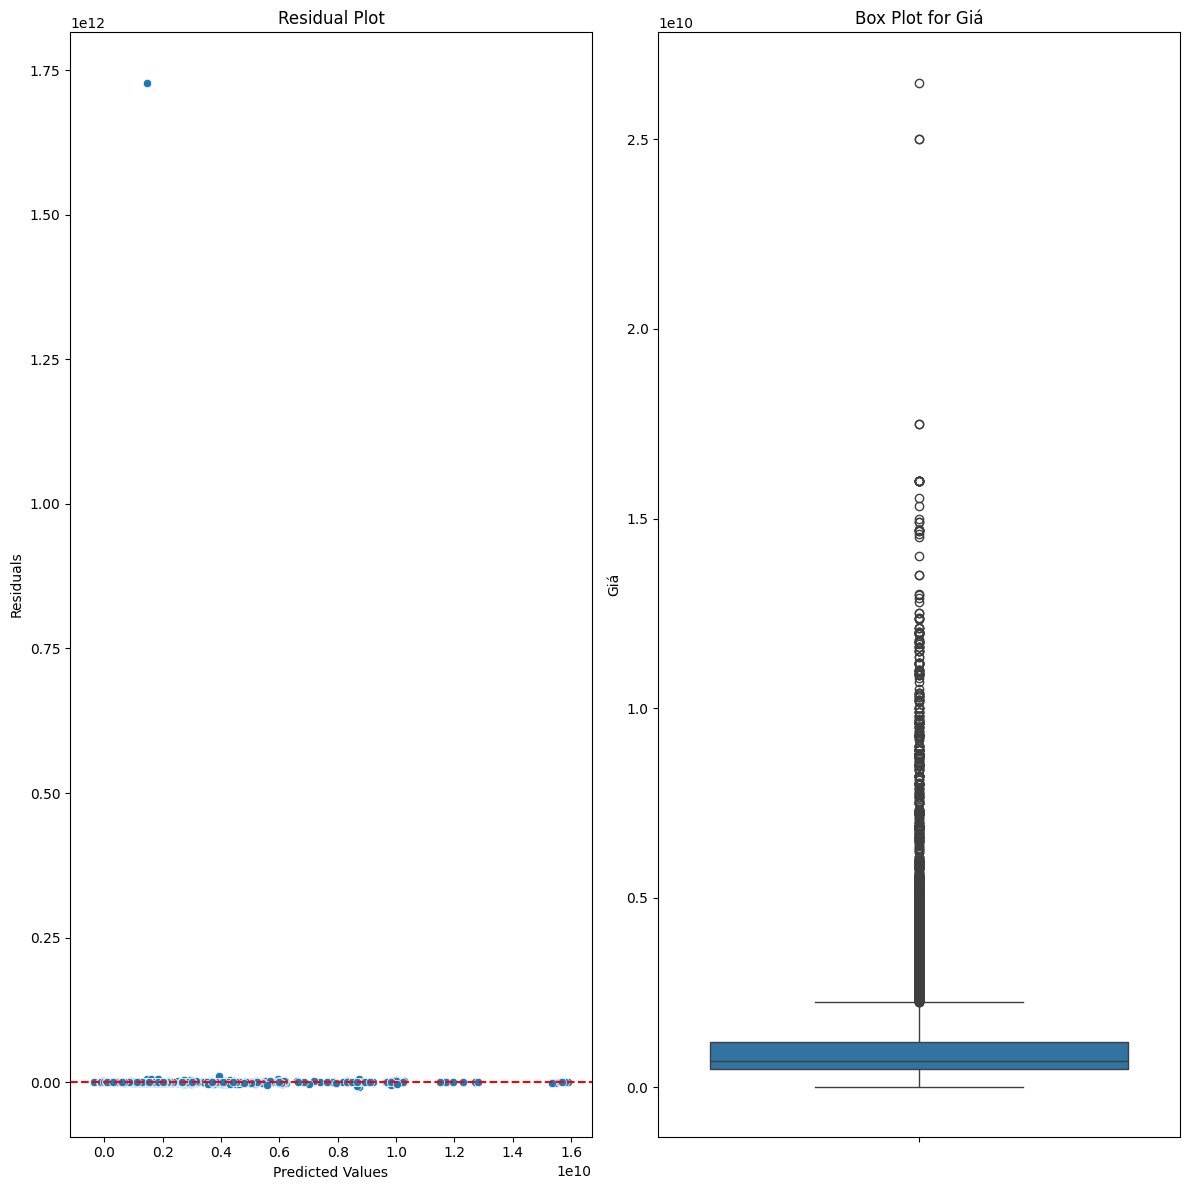

In [13]:
# Create a 1x2 subplot grid
plt.figure(figsize=(12, 12))

# Subplot 1: Residual Plot
plt.subplot(1, 2, 1)
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Subplot 2: Box Plot for y_train
plt.subplot(1, 2, 2)
sns.boxplot(y=y_train)
plt.title('Box Plot for Giá')
plt.ylabel('Giá')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined Giá
plt.show()


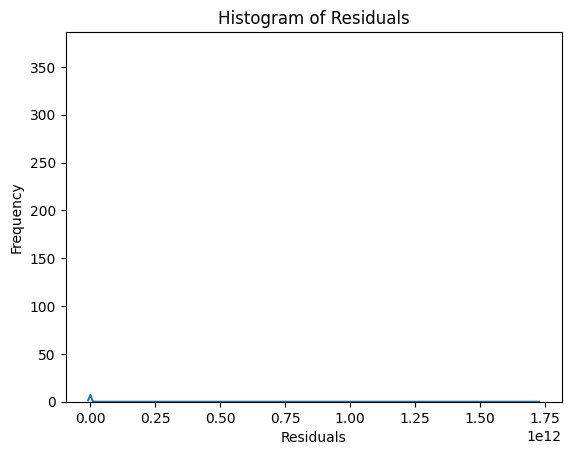

In [14]:
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

### Kết luận....

## KNN

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Standardize the data
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(OH_X_train)
X_test_scaled = scaler.transform(OH_X_test)

# Apply PCA with arpack solver
pca = PCA(n_components=10, svd_solver='arpack')  # Specify the solver and choose a fixed number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Transform the target variable (log transformation)
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)

# Lists to store results
k_values = list(range(2, 9))
mse_values = []
r2_values = []
mae_values = []

for k in k_values:
    # Initialize the KNN regressor with the current k value
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    
    # Train the KNN model on the reduced data
    knn_regressor.fit(X_train_pca, y_train_transformed)

    # Make predictions on the reduced test data
    y_pred_transformed = knn_regressor.predict(X_test_pca)

    # Reverse the transformation of the target variable
    y_pred = np.expm1(y_pred_transformed)

    # Calculate MSE, R^2, and MAE for the current k value
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    mse_values.append(mse)
    r2_values.append(r2)
    mae_values.append(mae)

# Results
k_best_mse = k_values[np.argmin(mse_values)]
k_best_r2 = k_values[np.argmax(r2_values)]
k_best_mae = k_values[np.argmin(mae_values)]


In [16]:
mse_values, r2_values, mae_values

([5.660345227821505e+20,
  5.660977576873641e+20,
  5.6611755823324535e+20,
  5.6611075587324045e+20,
  5.661283411924254e+20,
  5.6625247466587016e+20,
  5.663504939600553e+20],
 [0.004497650001730191,
  0.0043864368261933295,
  0.004351612996263188,
  0.004363576516327572,
  0.004332648673820549,
  0.004114331310560937,
  0.003941941758724421],
 [535992125.36072576,
  551222419.9144183,
  557718822.713741,
  563225356.7246907,
  570588216.7247775,
  578021842.2661258,
  585194471.089217])

In [17]:
print("Best k:", k_best_mae)

Best k: 2


### Giải thích

### Tổng quan

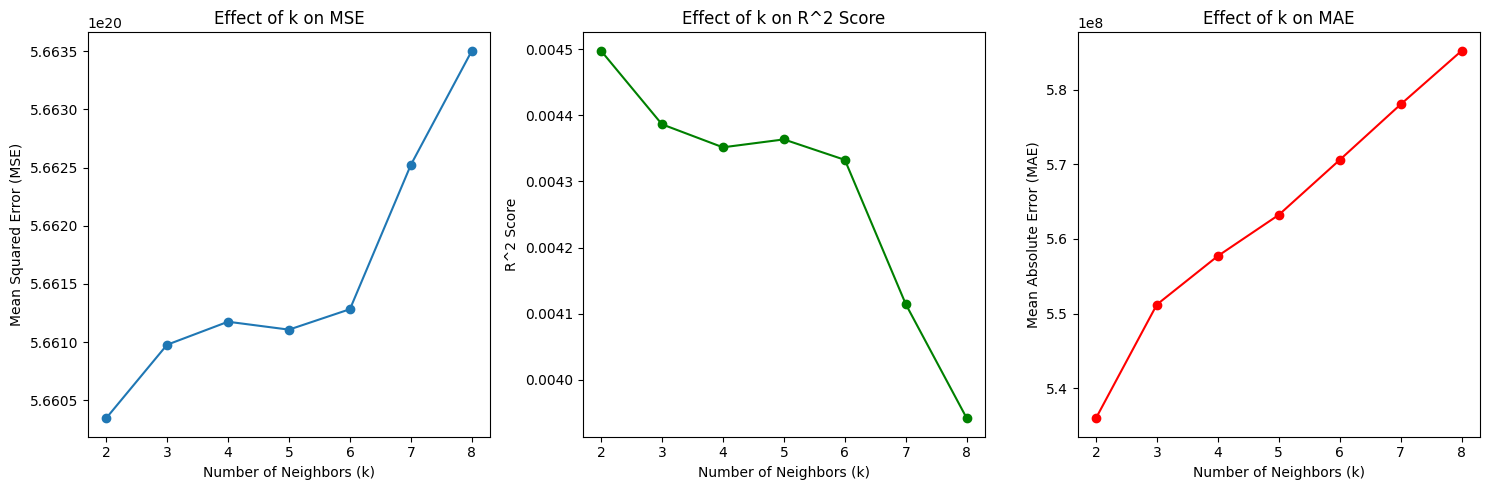

In [18]:
# Create a plot to visualize the effect of k on MSE, R^2, and MAE
plt.figure(figsize=(15, 5))

# Plot MSE
plt.subplot(1, 3, 1)
plt.plot(k_values, mse_values, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of k on MSE')

# Plot R^2
plt.subplot(1, 3, 2)
plt.plot(k_values, r2_values, marker='o', linestyle='-', color='green')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R^2 Score')
plt.title('Effect of k on R^2 Score')

# Plot MAE
plt.subplot(1, 3, 3)
plt.plot(k_values, mae_values, marker='o', linestyle='-', color='red')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Effect of k on MAE')

plt.tight_layout()
plt.show()

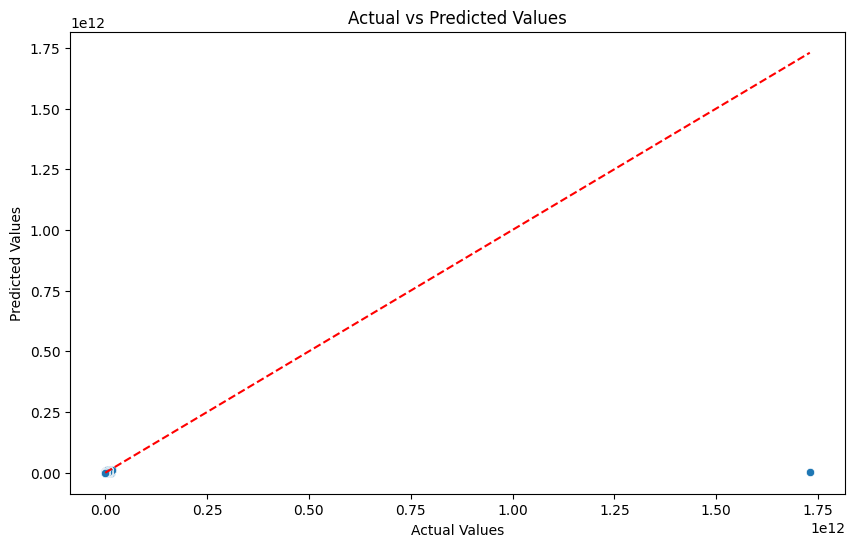

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

## Decision Tree

In [20]:
# Initialize the Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model on the transformed and encoded data
dt_model.fit(OH_X_train, y_train)

# Predictions on the test data
y_pred = dt_model.predict(OH_X_test)

# Calculate the MSE, R^2, and MAE metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 5.6552949478647117e+20
Mean Absolute Error: 451037157.92397845
R^2 Score: 0.00538585829341276


### Giải thích

### Visualization

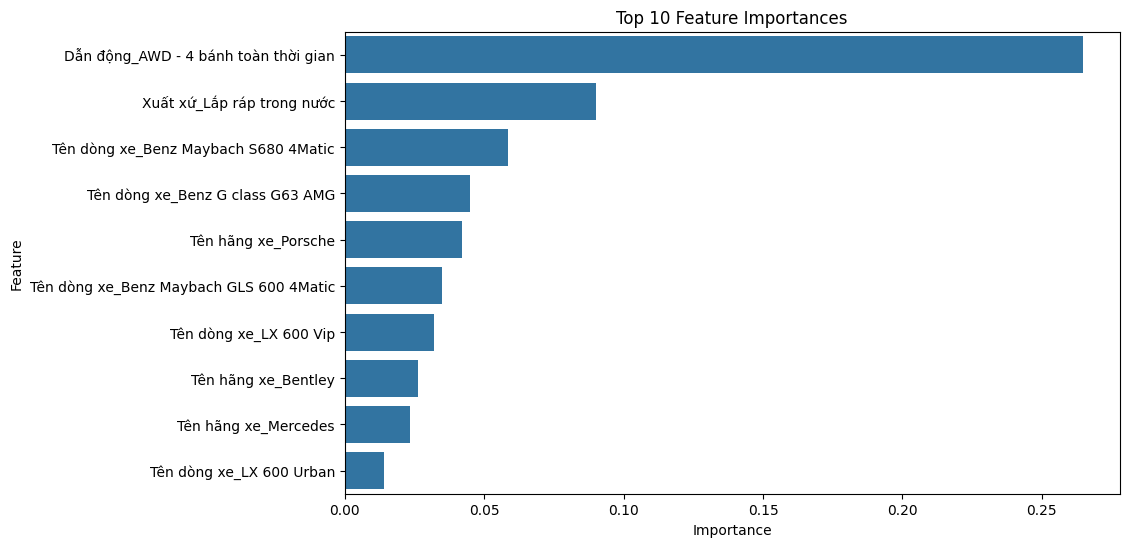

In [21]:
feature_importances = dt_model.feature_importances_
feature_names = OH_encoder.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

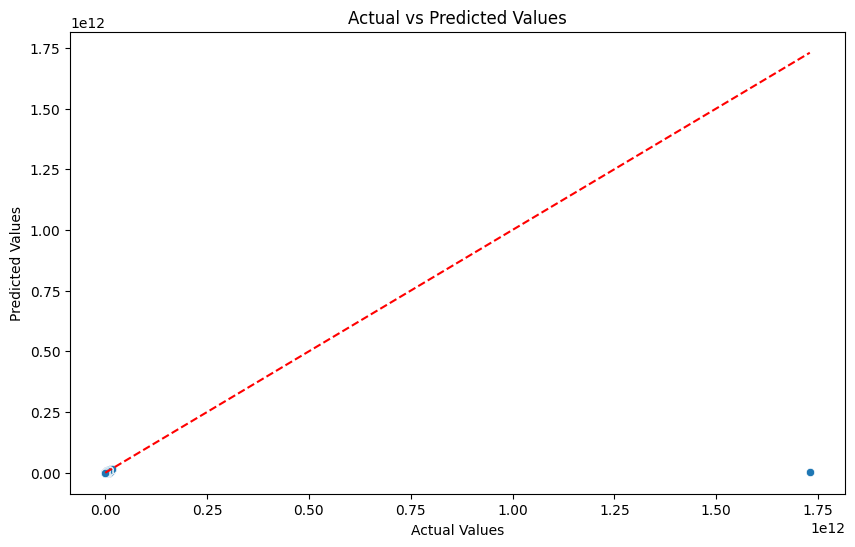

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

### Tổng kết

## Gradient Boosting Regression

In [23]:
# Initialize the Gradient Boosting Regressor model
gbdt_model = GradientBoostingRegressor(random_state=42)

# Train the model on the transformed and encoded data
gbdt_model.fit(OH_X_train, y_train)

# Predictions on the test data
y_pred = gbdt_model.predict(OH_X_test)

# Calculate the MSE, R^2, and MAE metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 5.665359034272095e+20
R^2: 0.003615856417927943
Mean Absolute Error: 737936953.3603802


### Giải thích

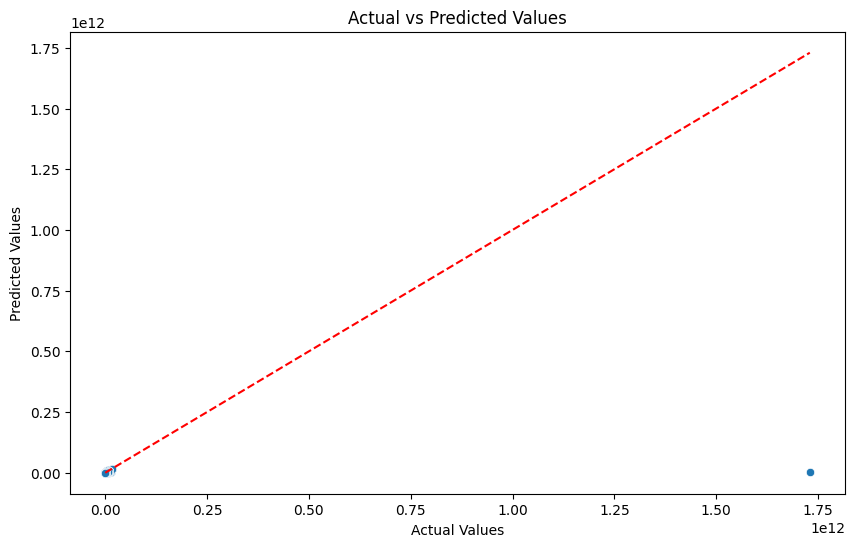

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()